In [132]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib import style
style.use('ggplot')


In [133]:
PROJECT_ID = "ninth-nebula-475418-p4"
DATASET = "movie_review"
TABLE = "movie_review_imdb"

client = bigquery.Client(project=PROJECT_ID)

query = f"""
SELECT *
FROM `{PROJECT_ID}.{DATASET}.{TABLE}`
"""

df = client.query(query).to_dataframe()
df.head()

,review,sentiment
0,Basically there's a family where a little boy ...,negative
1,"This show was an amazing, fresh & innovative i...",negative
2,Encouraged by the positive comments about this...,negative
3,Phil the Alien is one of those quirky films wh...,negative
4,I saw this movie when I was about 12 when it c...,negative


In [134]:
df.shape


(50001, 2)

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50001 non-null  object
 1   sentiment  50001 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Text(0.5, 1.0, 'Sentiment distribution')

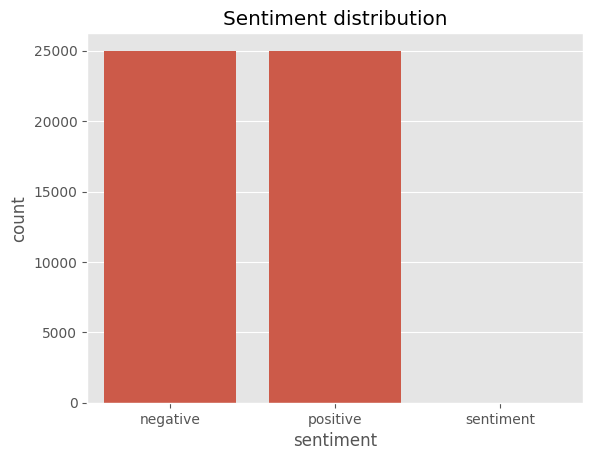

In [136]:
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment distribution")

In [137]:
for i in range(5):
    print("Review: ", [i])
    print(df['review'].iloc[i], "\n")
    print("Sentiment: ", df['sentiment'].iloc[i], "\n\n")

Review:  [0]
Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them. 

Sentiment:  negative 


Review:  [1]
This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny any

In [138]:
def no_of_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [139]:
df['word count'] = df['review'].apply(no_of_words)

In [140]:
df.head()

,review,sentiment,word count
0,Basically there's a family where a little boy ...,negative,138
1,"This show was an amazing, fresh & innovative i...",negative,174
2,Encouraged by the positive comments about this...,negative,130
3,Phil the Alien is one of those quirky films wh...,negative,96
4,I saw this movie when I was about 12 when it c...,negative,180


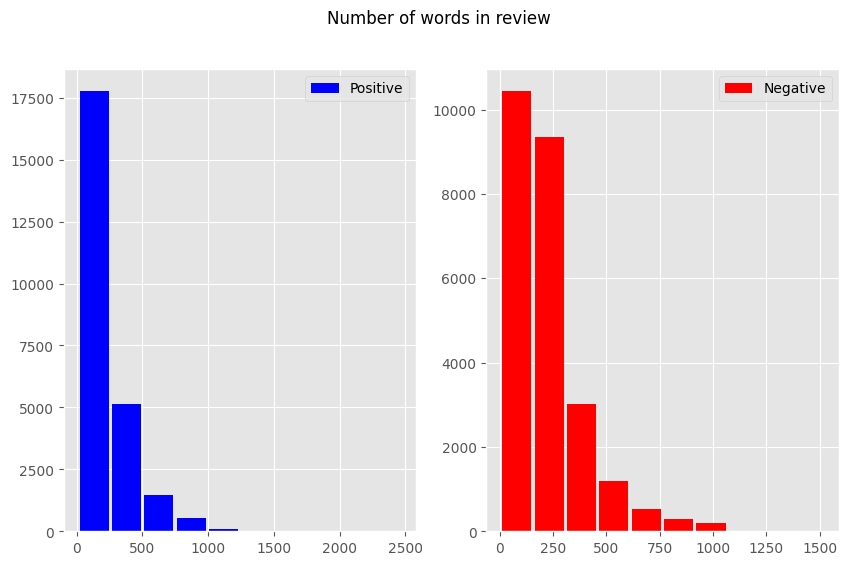

In [141]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].hist(df[df['sentiment'] == 'positive']['word count'], label='Positive', color='blue', rwidth=0.9);
ax[0].legend(loc='upper right');
ax[1].hist(df[df['sentiment'] == 'negative']['word count'], label='Negative', color='red', rwidth=0.9);
ax[1].legend(loc='upper right');
fig.suptitle("Number of words in review")
plt.show()

Data Pre-Processing:-

In [142]:
df.head()

,review,sentiment,word count
0,Basically there's a family where a little boy ...,negative,138
1,"This show was an amazing, fresh & innovative i...",negative,174
2,Encouraged by the positive comments about this...,negative,130
3,Phil the Alien is one of those quirky films wh...,negative,96
4,I saw this movie when I was about 12 when it c...,negative,180


In [143]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Note: If you want to use Lemmatization (recommended), you would need to import
# nltk and WordNetLemmatizer, and update the data_processing function accordingly.

# =========================================================================
# 1. TEXT PREPROCESSING FUNCTION
# =========================================================================

def data_processing(text):
    """Performs cleanup and token filtering for the TF-IDF vectorizer."""
    # Normalization
    text = text.lower()
    text = re.sub('<br />', ' ', text)
    
    # Noise Removal
    text = re.sub(r"https?\S+|www\.\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text) # Remove punctuation
    text = re.sub(r'\d+', '', text)    # Remove numbers
    
    tokens = text.split()
    
    # Stop Word Filtering
    filtered = [t for t in tokens if t not in ENGLISH_STOP_WORDS]
    
    return " ".join(filtered)


# =========================================================================
# 2. DATA CLEANING AND PREPARATION (RESOLVES ALL VALUE ERRORS)
# =========================================================================

# --- ASSUMPTION: df is already loaded and contains 'review' and 'sentiment' columns ---

print("--- Data Pre-processing Status ---")

# A. Initial cleanup on the sentiment column
df['sentiment'] = df['sentiment'].astype(str).str.lower()
initial_rows = len(df)

# B. Replace target strings with numbers
df['sentiment'] = df['sentiment'].replace({
    "positive": 1,
    "negative": 0
})

# C. AGGRESSIVE FILTERING: Drop rows that failed to map to 0 or 1.
# This eliminates any residual strings (like 'sentiment' or 'nan')
valid_labels = df['sentiment'].isin([0, 1, 0.0, 1.0])
df = df.loc[valid_labels].copy() 
print(f"Dropped {initial_rows - len(df)} rows that contained invalid sentiment labels.")

# D. Apply Preprocessing to Reviews
# Note: We apply the preprocessing directly to the DataFrame column
df['review'] = df['review'].apply(data_processing)

# E. Final Type Conversion and Split
X = df['review']
# Use .values.ravel().astype(int) on the CLEANSED data for final structure
y = df['sentiment'].values.ravel().astype(int) 

# Split the Data (70% Training, 30% Testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
print(f"Final Training set size: {len(X_train)} samples")
print("-" * 40)


# =========================================================================
# 3. TF-IDF VECTORIZATION (Feature Engineering)
# =========================================================================

# Initialize the Vectorizer
vectorizer = TfidfVectorizer(
    # Note: The preprocessor argument is optional here since we cleaned the column upfront
    max_features=10000,
    ngram_range=(1, 1) # Using Unigrams for the baseline model
)

# A. Fit and Transform the Training Data
X_train_vectors = vectorizer.fit_transform(X_train)

# B. Transform the Test Data
X_test_vectors = vectorizer.transform(X_test)

print("\n--- TF-IDF Vectorization ---")
print(f"Training Vector Matrix Shape: {X_train_vectors.shape}")
print(f"Features (words): {X_train_vectors.shape[1]}")



# =========================================================================
# 4. LOGISTIC REGRESSION TRAINING AND EVALUATION
# =========================================================================

# Initialize and Train the Model
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train_vectors, y_train)

# Prediction and Evaluation
y_pred = model.predict(X_test_vectors)
accuracy = accuracy_score(y_test, y_pred)

print("\n--- Model Performance ---")
print("-" * 40)
print(f"Classification Model Accuracy: {accuracy:.4f}")
print("-" * 40)


# =========================================================================
# 5. FEATURE ANALYSIS (INTERPRETING THE MODEL)
# =========================================================================

# 1. Get the feature names and coefficients
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_[0]
feature_scores = pd.Series(coefficients, index=feature_names)

# 2. Extract Top 10 Positive and Negative Features
top_positive = feature_scores.sort_values(ascending=False).head(10)
top_negative = feature_scores.sort_values(ascending=True).head(10)

print("\n🏆 TOP 10 WORDS PREDICTIVE OF POSITIVE SENTIMENT:")
print(top_positive)

print("\n🗑️ TOP 10 WORDS PREDICTIVE OF NEGATIVE SENTIMENT:")
print(top_negative)

--- Data Pre-processing Status ---
Dropped 1 rows that contained invalid sentiment labels.


Final Training set size: 35000 samples
----------------------------------------

--- TF-IDF Vectorization ---
Training Vector Matrix Shape: (35000, 10000)
Features (words): 10000

--- Model Performance ---
----------------------------------------
Classification Model Accuracy: 0.8900
----------------------------------------

🏆 TOP 10 WORDS PREDICTIVE OF POSITIVE SENTIMENT:
great        7.508446
excellent    6.955078
best         5.620108
perfect      5.039057
amazing      4.966737
wonderful    4.713847
enjoyed      4.480893
favorite     4.340671
hilarious    4.269351
superb       4.185268
dtype: float64

🗑️ TOP 10 WORDS PREDICTIVE OF NEGATIVE SENTIMENT:
worst      -10.199063
awful       -7.623577
waste       -7.583148
bad         -7.103220
boring      -6.594815
terrible    -5.625110
worse       -5.391465
poor        -5.275060
poorly      -5.008694
horrible    -4.842998
dtype: float64


Random Forest & SVM

In [144]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB # New Import
from sklearn.metrics import accuracy_score
import time 

# --- ASSUMPTIONS ---
# X_train_vectors, X_test_vectors, y_train, and y_test are defined.
# results['Logistic Regression'] is set (e.g., 0.86).
# --------------------

results = {}
results['Logistic Regression'] = 0.86 # Your previous result

print("--- Starting Model Benchmarking ---")

# =========================================================================
# 1. RANDOM FOREST CLASSIFIER
# =========================================================================

print("\n[1/3] Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) 

start_time = time.time()
rf_model.fit(X_train_vectors, y_train)
end_time = time.time()

y_pred_rf = rf_model.predict(X_test_vectors)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
results['Random Forest'] = accuracy_rf

print(f"    -> Training Time: {end_time - start_time:.2f} seconds")
print(f"    -> Accuracy: {accuracy_rf:.4f}")


# =========================================================================
# 2. MULTINOMIAL NAIVE BAYES (REPLACEMENT FOR SVC)
# =========================================================================

print("\n[2/3] Training Multinomial Naive Bayes (MNB)...")

# MNB is ideal for sparse count/frequency data like TF-IDF vectors
nb_model = MultinomialNB()

start_time = time.time()
nb_model.fit(X_train_vectors, y_train) # Uses the same TF-IDF vectors
end_time = time.time()

# Prediction and Evaluation
y_pred_nb = nb_model.predict(X_test_vectors)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
results['MultinomialNB'] = accuracy_nb

print(f"    -> Training Time: {end_time - start_time:.2f} seconds")
print(f"    -> Accuracy: {accuracy_nb:.4f}")


# =========================================================================
# 3. COMPARISON RESULTS
# =========================================================================

print("\n" + "=" * 50)
print("              FINAL MODEL COMPARISON")
print("=" * 50)
for model_name, accuracy in results.items():
    print(f"{model_name:<25} Accuracy: {accuracy:.4f}")
print("=" * 50)

--- Starting Model Benchmarking ---

[1/3] Training Random Forest...
    -> Training Time: 10.53 seconds
    -> Accuracy: 0.8509

[2/3] Training Multinomial Naive Bayes (MNB)...
    -> Training Time: 0.01 seconds
    -> Accuracy: 0.8575

              FINAL MODEL COMPARISON
Logistic Regression       Accuracy: 0.8600
Random Forest             Accuracy: 0.8509
MultinomialNB             Accuracy: 0.8575


In [145]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# --- ASSUMPTIONS ---
# 1. X_test_vectors, y_test are available.
# 2. LogReg model (model) and Naive Bayes model (nb_model) are already trained.
# --------------------

def evaluate_model_advanced(model, X_test, y_test, model_name):
    """Calculates and prints the Classification Report and AUC Score."""
    
    print("\n" + "=" * 60)
    print(f"       ADVANCED EVALUATION: {model_name}")
    print("=" * 60)

    # 1. Predictions for Report (Hard classes: 0 or 1)
    y_pred = model.predict(X_test)
    
    # 2. Probability Predictions for AUC (The confidence score)
    # Most sklearn models use predict_proba for probability estimates
    y_proba = model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class (class 1)

    # --- Classification Report ---
    print("\n[A] Classification Report (Precision, Recall, F1-Score):")
    # target_names will show '0' and '1' as class labels.
    report = classification_report(y_test, y_pred, target_names=['Negative (0)', 'Positive (1)'])
    print(report)

    # --- AUC-ROC Score ---
    try:
        auc_score = roc_auc_score(y_test, y_proba)
        print("-" * 60)
        print(f"[B] Area Under the ROC Curve (AUC): {auc_score:.4f}")
        print("-" * 60)
    except Exception as e:
        print(f"Could not calculate AUC: {e}")
        # Note: AUC calculation requires the model to support predict_proba

    return auc_score

# ====================================================================
# Run Evaluation on Both Models
# ====================================================================

# 1. Evaluate Logistic Regression (your best model by accuracy)
lr_auc = evaluate_model_advanced(model, X_test_vectors, y_test, "Logistic Regression")

# 2. Evaluate Multinomial Naive Bayes (the fastest model)
mnb_auc = evaluate_model_advanced(nb_model, X_test_vectors, y_test, "Multinomial Naive Bayes")


# Final Comparative Summary
print("\n" + "#" * 60)
print("     AUC-ROC Score Comparison (Higher is Better)")
print("#" * 60)
print(f"Logistic Regression AUC: {lr_auc:.4f}")
print(f"Multinomial Naive Bayes AUC: {mnb_auc:.4f}")
print("#" * 60)


       ADVANCED EVALUATION: Logistic Regression

[A] Classification Report (Precision, Recall, F1-Score):
              precision    recall  f1-score   support

Negative (0)       0.90      0.88      0.89      7526
Positive (1)       0.88      0.90      0.89      7474

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000

------------------------------------------------------------
[B] Area Under the ROC Curve (AUC): 0.9584
------------------------------------------------------------

       ADVANCED EVALUATION: Multinomial Naive Bayes

[A] Classification Report (Precision, Recall, F1-Score):
              precision    recall  f1-score   support

Negative (0)       0.86      0.86      0.86      7526
Positive (1)       0.86      0.86      0.86      7474

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg      